In [7]:
# -*- coding: utf-8 -*-
"""Untitled80.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1uXpyQRKM1yyJ5BY-NlDbNrUJaUrvD4KA
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define tolerance
tol = 1e-6
# %matplotlib inline
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp
def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])
    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv
def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((1,2))
        weights = 4
    return weights,locations
def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(1)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
E = 2e11
h = 0.01
pois = 0.3
Lx = 1
Ly = 1
E1 =E/(1-pois**2)
C = E1*np.array([[1,     pois,   0],
                 [pois,   1,     0],
                 [0,      0,   (1-pois)/2]])
dfnode = pd.read_csv('NLIST1.csv', header=None)
dfnode.head()
dfnode = dfnode.dropna(axis=0)
dfnode.head()
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP
xy = dfnode.iloc[:,1:3]
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
dfeNode = pd.read_csv('/content/ELIST1.csv', header=None)
dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]
eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]
eNodes.head()
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape
PlotMeshb(xy,eNodes,nE)
K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h)
K.shape
fixP = np.argwhere(xy[:,0]<=tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof
dfx = 1e8
dx = 1/20
dy = 1/20
force = np.zeros((nDof,1))
loadP1 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=Ly-tol))
loadP2 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]<=tol))
loadP3 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=tol) & (xy[:,1]<=Ly-tol))
force[loadP1,0] = dfx*dy/2
force[loadP2,0] = dfx*dy/2
force[loadP3,0] = dfx*dy
disp = solution(nDof,fixDof,K,force)
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]
max(dispu)
max(dispv)
min(dispv)

-0.00776740702019414

In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
def sol(nDof, fixDof, K, force):
    ad = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(ad, ad)], force[ad])
    d = np.zeros((nDof, 1))
    d[ad] = U
    return d
def sf(xi, eta):
    s = np.zeros((4, 1))
    s[:, 0] = 1/4 * np.array([(1 - xi)*(1 - eta), (1 + xi)*(1 - eta), (1 + xi)*(1 + eta), (1 - xi)*(1 + eta)])
    nd = np.zeros((4, 2))
    nd[0, :] = 1/4 * np.array([-(1 - eta), -(1 - xi)])
    nd[1, :] = 1/4 * np.array([1 - eta, -(1 + xi)])
    nd[2, :] = 1/4 * np.array([1 + eta, 1 + xi])
    nd[3, :] = 1/4 * np.array([-(1 + eta), 1 - xi])
    return s, nd
def J(nc, nd):
    j = np.matmul(np.transpose(nc), nd)
    bt = np.transpose(nd)
    at = j.T
    xt = np.linalg.solve(at, bt)
    xyd = np.transpose(xt)
    return j, xyd
def gq(o):
    if o == 1:
        l = np.array([[-0.577350269189626, -0.577350269189626],[0.577350269189626, -0.577350269189626],[0.577350269189626,  0.577350269189626],[-0.577350269189626, 0.577350269189626]])
        w = np.ones((4, 1))
    else:
        l = np.zeros((1, 2))
        w = 4
    return w, l

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# Define tolerance
tol = 1e-6

def sol(nDof, fixDof, K, force):
    ad = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(ad, ad)], force[ad])
    d = np.zeros((nDof, 1))
    d[ad] = U
    return d

def sf(xi, eta):
    s = np.zeros((4, 1))
    s[:, 0] = 1/4 * np.array([(1 - xi)*(1 - eta), (1 + xi)*(1 - eta), (1 + xi)*(1 + eta), (1 - xi)*(1 + eta)])
    nd = np.zeros((4, 2))
    nd[0, :] = 1/4 * np.array([-(1 - eta), -(1 - xi)])
    nd[1, :] = 1/4 * np.array([1 - eta, -(1 + xi)])
    nd[2, :] = 1/4 * np.array([1 + eta, 1 + xi])
    nd[3, :] = 1/4 * np.array([-(1 + eta), 1 - xi])
    return s, nd

def calculateJacobian(nc, nd):
    j = np.matmul(np.transpose(nc), nd)
    bt = np.transpose(nd)
    at = j.T
    xt = np.linalg.solve(at, bt)
    xyd = np.transpose(xt)
    return j, xyd

def gq(o):
    if o == 1:
        l = np.array([[-0.577350269189626, -0.577350269189626],[0.577350269189626, -0.577350269189626],[0.577350269189626,  0.577350269189626],[-0.577350269189626, 0.577350269189626]])
        w = np.ones((4, 1))
    else:
        l = np.zeros((1, 2))
        w = 4
    return w, l

def formStiffness2D(nDof, nE, eNodes, nP, xy, C, h):
    K = np.zeros((nDof, nDof))
    gaussWt, gaussLoc = gq(1)
    for e in range(nE):
        id = eNodes[e, :]
        eDof = np.zeros((8, 1))
        eDof[0:4, 0] = id
        eDof[4:8, 0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q, :]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape, nDeriv = sf(xi, eta)

            # Jacobian matrix, inverse of Jacobian
            jacobian, xyDeriv = calculateJacobian(xy[id - 1, :], nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3, 2 * ndof))
            B[0, 0:ndof] = np.transpose(xyDeriv[:, 0])
            B[1, ndof:(2 * ndof)] = np.transpose(xyDeriv[:, 1])
            B[2, 0:ndof] = np.transpose(xyDeriv[:, 1])
            B[2, ndof:(2 * ndof)] = np.transpose(xyDeriv[:, 0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(jacobian)
            Ke = np.matmul(np.matmul(BT, C), B) * h * detJ * gaussWt[q]
            for ii in range(np.size(Ke, 0)):
                row = int(eDof[ii]) - 1
                for jj in range(np.size(Ke, 1)):
                    col = int(eDof[jj]) - 1
                    K[row, col] = K[row, col] + Ke[ii, jj]
    return K

def plot_sparse_matrix(matrix):
    plt.figure(figsize=(8, 8))
    plt.spy(matrix, markersize=1)
    plt.title("Sparse Matrix Visualization")
    plt.show()

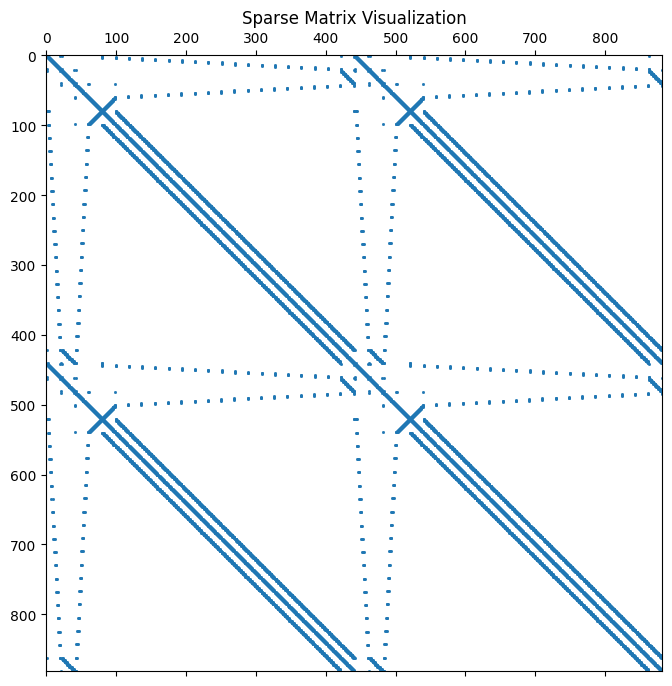

In [16]:
# Calculate stiffness matrix
K = formStiffness2D(nDof, nE, eNodes, nP, xy, C, h)

# Plot the sparse matrix
sparse_K = coo_matrix(K)
plot_sparse_matrix(sparse_K)

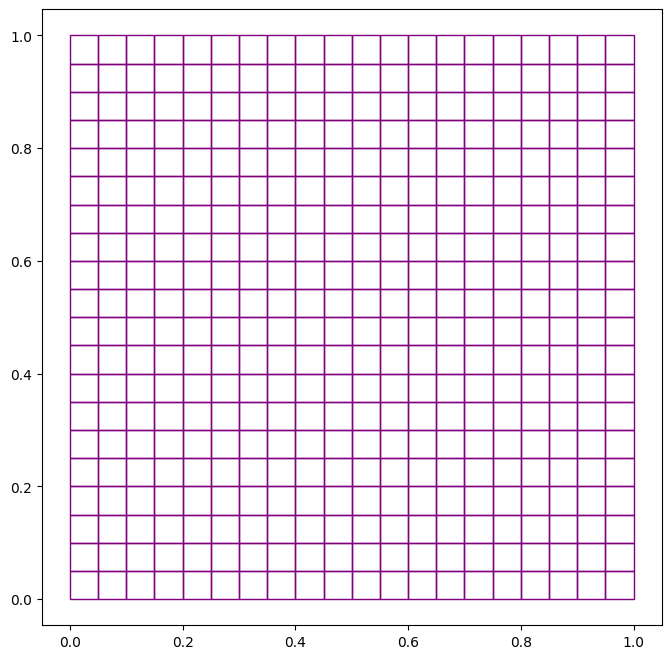

-0.00776740702019414

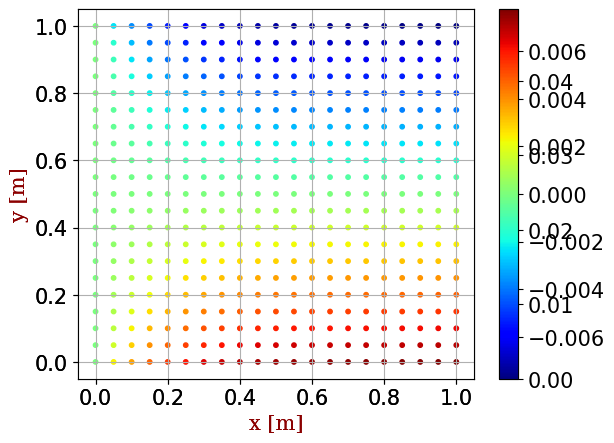

In [17]:
# -*- coding: utf-8 -*-
"""FEM_Plate_Q4_Ex1.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1nLsCB72wGplPhZvxfET7syzSndb1cSn3

# 2D plate
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

"""# Part I: Functions

## 1. Solution Function: used for solving: K*U = F
"""

def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

"""## 2. Shape function Q4"""

def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv

"""## 3. Jacobian Function"""

def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)

    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

"""## 4. Gauss Quadrature-Q4"""

def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((1,2))
        weights = 4
    return weights,locations

"""## 5. Stiffness matrix function - Q4"""

def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(1)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

"""## 6. Function_Plot mesh"""

# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

"""# Part 2: Main Programe

## 2.1. Input parameters: geometry & material
"""

# Material Pros
E = 2e11
h = 0.01
pois = 0.3
Lx = 1
Ly = 1

# This is the tolerance that we will use for our code
tol = 1e-6

# Stress- strain matriz: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matriz: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1,     pois,   0],
                 [pois,   1,     0],
                 [0,      0,   (1-pois)/2]])

"""## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates
"""

dfnode = pd.read_csv('NLIST1.csv', header=None)
dfnode.head()

dfnode = dfnode.dropna(axis=0)
dfnode.head()

dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,1:3]
# xy

xy = xy.reset_index()
xy = xy.iloc[:,1:3]
# xy = xy.to_numpy()
xy = xy.to_numpy(dtype=np.float32)
# xy

"""### 2.2.2. Import nodal connectivities"""

dfeNode = pd.read_csv('ELIST1.csv', header=None)
dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]

eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]

eNodes.head()

eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

"""### 2.2.3 plot mesh"""

PlotMeshb(xy,eNodes,nE)

"""## 2.3. Calculate stiffness matrix"""

K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h)
K.shape

"""## 2.4 Boundary condition"""

fixP = np.argwhere(xy[:,0]<=tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof

"""## 2.5 Loading"""

dfx = 1e8
dx = 1/20
dy = 1/20

force = np.zeros((nDof,1))
loadP1 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=Ly-tol))
loadP2 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]<=tol))
loadP3 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=tol) & (xy[:,1]<=Ly-tol))
force[loadP1,0] = dfx*dy/2
force[loadP2,0] = dfx*dy/2
force[loadP3,0] = dfx*dy

"""## 2.6. Solve EOM: K*U=F"""

disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

pd.DataFrame(dispu).to_csv('dispu.csv')
pd.DataFrame(dispv).to_csv('dispv.csv')

"""## 2.7. Postprocessing"""

## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xy[:,0], xy[:,1], s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

plt.savefig('dispU', bbox_inches='tight', dpi=300)

max(dispu)

## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xy[:,0], xy[:,1], s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

plt.savefig('dispV', bbox_inches='tight', dpi=300)

max(dispv)

min(dispv)


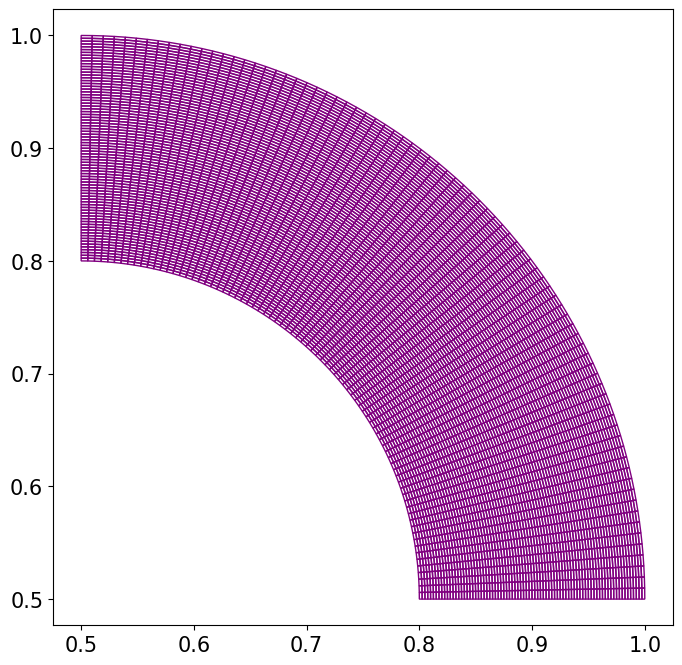

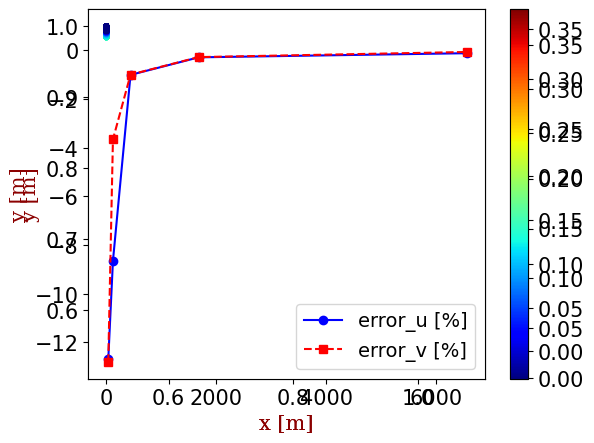

In [18]:
# -*- coding: utf-8 -*-
"""FEM_Plate_Q4_EX2.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1eU878kAyTtnw2PaWPTpburZMeFb54C32

# 2D plate
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

"""# Part I: Functions

## 1. Solution Function
"""

def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

"""## 2. Shape function Q4"""

def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv

"""## 3. Jacobian Function"""

def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)

    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

"""## 4. Gauss Quadrature-Q4"""

def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((2,1))
        weights = 4*np.ones((1,1))
    return weights,locations

"""## 5. Stiffness matrix function - Q4"""

def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h,gauss_quad_opt):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(gauss_quad_opt)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]

            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

"""## 6. Function_Plot mesh"""

# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

"""# Part 2: Main Programe

## 2.1. Input parameters: geometry & material
"""

# Material Pros
E = 2e11
h = 0.01
pois = 0.3
R1 = 0.4
R2 = 0.5
tol = 1e-6

# Stress- strain matriz: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matriz: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1, pois, 0],[pois, 1, 0],[0, 0, (1-pois)/2]])

"""## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates
"""

# dfnode = pd.read_csv('NLISTQ4_NDIV5.csv', header=None)
# dfnode = pd.read_csv('NLISTQ4_NDIV10.csv', header=None)
# dfnode = pd.read_csv('NLISTQ4_NDIV20.csv', header=None)
# dfnode = pd.read_csv('NLISTQ4_NDIV40.csv', header=None)
dfnode = pd.read_csv('NLISTQ4_NDIV80.csv', header=None)

# dfnode.head(10)

dfnode = dfnode.dropna(axis=0)
dfnode.head()

dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,1:3]
type(xy)

xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
# xy

"""### 2.2.2. Import nodal connectivities"""

# dfeNode = pd.read_csv('ELISTQ4_NDIV5.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ4_NDIV10.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ4_NDIV20.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ4_NDIV40.csv', header=None)
dfeNode = pd.read_csv('ELISTQ4_NDIV80.csv', header=None)

dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]

eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]

eNodes.head()

eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

"""### 2.2.3 plot mesh"""

PlotMeshb(xy,eNodes,nE)

"""## 2.3. Calculate stiffness matrix"""

K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h,1)
K.shape

"""## 2.4 Boundary condition"""

fixP = np.argwhere(xy[:,0]<=R2+tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof

"""## 2.5 Loading"""

dfx = 5e7
force = np.zeros((nDof,1))

loadP3 = np.argwhere((xy[:,0]>=2*R1-tol) & (xy[:,1]<=R2+tol))
# loadP3
sort_index = np.argsort(xy[loadP3,0].flatten())
# sort_index

loadP = loadP3.copy()
for i in range(len(sort_index)):
    idi = sort_index[i]
    loadP[i] = loadP3[idi,0]
# loadP

for i in range(len(loadP)-1):
    i0 = loadP[i]
    i1 = loadP[i+1]
    dist = np.sqrt((xy[i0,0]-xy[i1,0])**2 + (xy[i0,1]-xy[i1,1])**2)
    force[i0,0] = force[i0,0] + dfx*dist/2
    force[i1,0] = force[i1,0] + dfx*dist/2
# force[loadP]

"""## 2.6. Solve EOM"""

disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

"""## 2.7. Postprocessing"""

scale = 0.2
xNew = xy[:,0] + scale*dispu
yNew = xy[:,1] + scale*dispv

## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

max(dispu)

## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)

plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

max(dispv)

nPQ4 = np.array([36, 121, 441, 1681, 6561])

error_u = np.array([-12.70,-8.65,-1.01,-0.29,-0.12]) # %
error_v = np.array([-12.80,-3.66,-1.00,-0.28,-0.07]) # %

# plot relative errors(%) between ANSYS and our Python code
plt.rc('font', size=14)
plt.plot(nPQ4, error_u,'ob-', label="error_u [%]")
plt.plot(nPQ4, error_v,'sr--', label="error_v [%]")
plt.grid()
plt.legend()



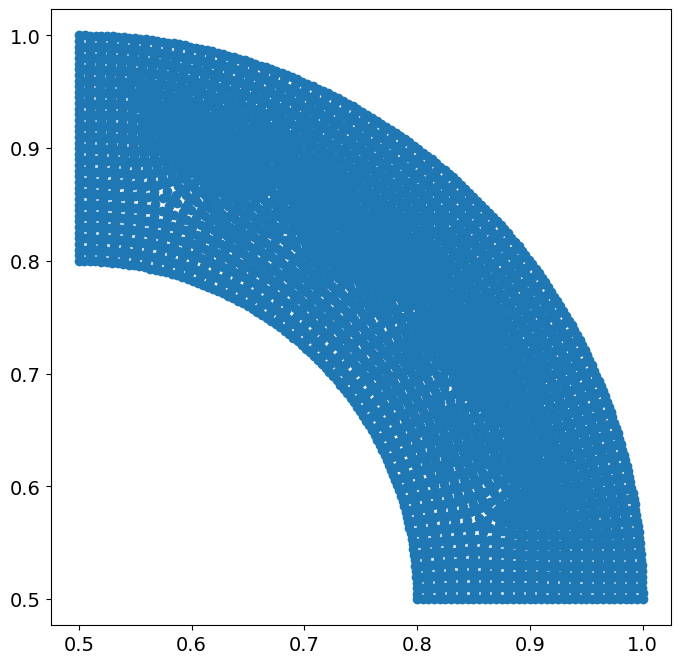

0.3701421390021699

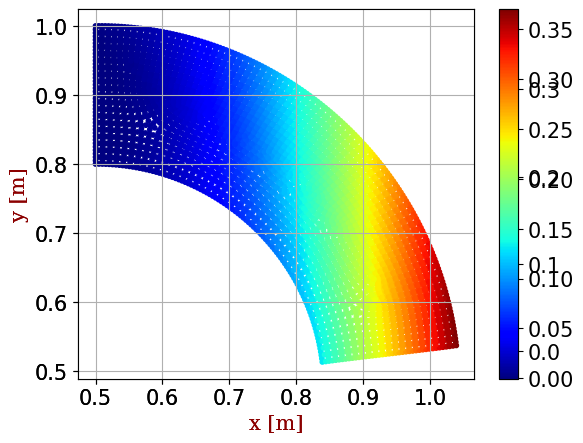

In [19]:
# -*- coding: utf-8 -*-
"""FEM_Plate_Q8.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1G0kMwvOejqo4I_61N8ocs4kHOmZtIrfz

# 2D plate
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

"""# Part I: Functions

## 1. Solution Function
"""

def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

"""## 2. Shape function Q8"""

def shapeFuncQ8(xi,eta):
    shape = np.zeros((8,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta)*(-xi-eta-1),
                               (1+xi)*(1-eta)*(xi-eta-1),
                               (1+xi)*(1+eta)*(xi+eta-1),
                               (1-xi)*(1+eta)*(-xi+eta-1),
                               2*(1-xi*xi)*(1-eta),
                               2*(1+xi)*(1-eta*eta),
                               2*(1-xi*xi)*(1+eta),
                               2*(1-xi)*(1-eta*eta)])

    nderiv = np.zeros((8,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta)*(-xi-eta-1)-(1-xi)*(1-eta),-(1-xi)*(-xi-eta-1)-(1-xi)*(1-eta)])
    nderiv[1,:] = 1/4*np.array([(1-eta)*(xi-eta-1)+(1+xi)*(1-eta),-(1+xi)*(xi-eta-1)-(1+xi)*(1-eta)])
    nderiv[2,:] = 1/4*np.array([(1+eta)*(xi+eta-1)+(1+xi)*(1+eta),(1+xi)*(xi+eta-1)+(1+xi)*(1+eta)])
    nderiv[3,:] = 1/4*np.array([-(1+eta)*(-xi+eta-1)-(1-xi)*(1+eta),(1-xi)*(-xi+eta-1)+(1-xi)*(1+eta)])

    nderiv[4,:] = 1/2*np.array([(-2*xi)*(1-eta),-(1-xi*xi)])
    nderiv[5,:] = 1/2*np.array([(1-eta*eta),(1+xi)*(-2*eta)])
    nderiv[6,:] = 1/2*np.array([(-2*xi)*(1+eta),(1-xi*xi)])
    nderiv[7,:] = 1/2*np.array([-(1-eta*eta),(1-xi)*(-2*eta)])

    return shape, nderiv

"""## 3. Jacobian Function"""

def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)

    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

"""## 4.Gauss Quadrature Q8"""

def gaussQuadratureQ8(option):
    if option == 2: # full 2nd order integration: 3x3=9 gauss points
        locations = np.array([[-np.sqrt(3/5), -np.sqrt(3/5)],
                              [0, -np.sqrt(3/5)],
                              [np.sqrt(3/5),  -np.sqrt(3/5)],
                              [-np.sqrt(3/5), 0],
                              [0, 0],
                              [np.sqrt(3/5), 0],
                              [-np.sqrt(3/5),  np.sqrt(3/5)],
                              [0, np.sqrt(3/5)],
                              [np.sqrt(3/5),  np.sqrt(3/5)]])
        weights = np.array([[25/81],[40/81],[25/81],[40/81],[64/81],[40/81],[25/81],[40/81],[25/81]])

    elif option == 1: # (linear)integration: 2x2=4 gauss points
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))

    else: # 1x1=1: one gauss point
        locations =np.zeros((1,2))
        weights = 4*np.ones((1,1))

    return weights,locations

"""## 5. Stiffness matrix Q8"""

def formStiffness2DQ8(nDof,nE,eNodes,nP,xy,C,h,gauss_quad_opt):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadratureQ8(gauss_quad_opt)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((16,1))
        eDof[0:8,0] = id
        eDof[8:16,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop over Gauss points
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ8(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]

            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

"""## 7. Function_Plot mesh"""

# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
###    plt.show()

# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nE):
    # nE = element number
    nnel = np.size(eNodes,1) # number of nodes per element
    X = np.zeros((nnel,nE))
    Y = np.zeros((nnel,nE))

    for iel in range(nE):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
###     plt.show()

"""# Part 2: Main Programe

## 2.1. Input parameters: geometry & material
"""

# Material Pros
E = 2e11
h = 0.01
pois = 0.3
R1 = 0.4
R2 = 0.5
tol = 1e-6

# Stress- strain matriz: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matriz: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1, pois, 0],[pois, 1, 0],[0, 0, (1-pois)/2]])

"""## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates
"""

# dfnode = pd.read_csv('NLISTQ8a.csv', header=None)
# dfnode = pd.read_csv('NLISTQ8b.csv', header=None)
# dfnode = pd.read_csv('NLISTQ8c.csv', header=None)
dfnode = pd.read_csv('NLISTQ8d.csv', header=None)

dfnode.head(5)

dfnode = dfnode.dropna(axis=0)
dfnode.head()

dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,1:3]
type(xy)

xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
# xy

"""### 2.2.2. Import nodal connectivities"""

# dfeNode = pd.read_csv('ELISTQ8a.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ8b.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ8c.csv', header=None)
dfeNode = pd.read_csv('ELISTQ8d.csv', header=None)

dfeNode = dfeNode.dropna(axis=0)
# dfeNode.head(10)

eNodes = dfeNode[[6,7,8,9,10,11,12,13]]
eNodes.head()
nE = eNodes.count(axis=0)
nE = nE[6]

eNodes.head(2)

eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

"""### 2.2.3 plot mesh"""

eNodesb = eNodes.copy()
eNodesb[:,0] = eNodes[:,0]
eNodesb[:,1] = eNodes[:,4]
eNodesb[:,2] = eNodes[:,1]
eNodesb[:,3] = eNodes[:,5]
eNodesb[:,4] = eNodes[:,2]
eNodesb[:,5] = eNodes[:,6]
eNodesb[:,6] = eNodes[:,3]
eNodesb[:,7] = eNodes[:,7]

PlotMeshb(xy,eNodesb,nE)
plt.scatter(xy[:,0],xy[:,1])
plt.show()

"""## 2.3. Calculate stiffness matrix"""

K = formStiffness2DQ8(nDof,nE,eNodes,nP,xy,C,h,2)
K.shape

"""## 2.4 Boundary condition"""

fixP = np.argwhere(xy[:,0]<=R2+tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof

"""## 2.5 Loading"""

dfx = 5e7
force = np.zeros((nDof,1))

loadP3 = np.argwhere((xy[:,0]>=2*R1-tol) & (xy[:,1]<=R2+tol))
# loadP3
sort_index = np.argsort(xy[loadP3,0].flatten())
# sort_index

loadP = loadP3.copy()
for i in range(len(sort_index)):
    idi = sort_index[i]
    loadP[i] = loadP3[idi,0]
loadP

for i in range(len(loadP)-1):
    i0 = loadP[i]
    i1 = loadP[i+1]
    dist = np.sqrt((xy[i0,0]-xy[i1,0])**2 + (xy[i0,1]-xy[i1,1])**2)
    force[i0,0] = force[i0,0] + dfx*dist/2
    force[i1,0] = force[i1,0] + dfx*dist/2
# force[loadP]

"""## 2.6. Solve EOM"""

disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

"""## 2.7. Postprocessing"""

scale = 0.1
xNew = xy[:,0] + scale*dispu
yNew = xy[:,1] + scale*dispv

## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

max(dispu)

## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)

plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

max(dispv)

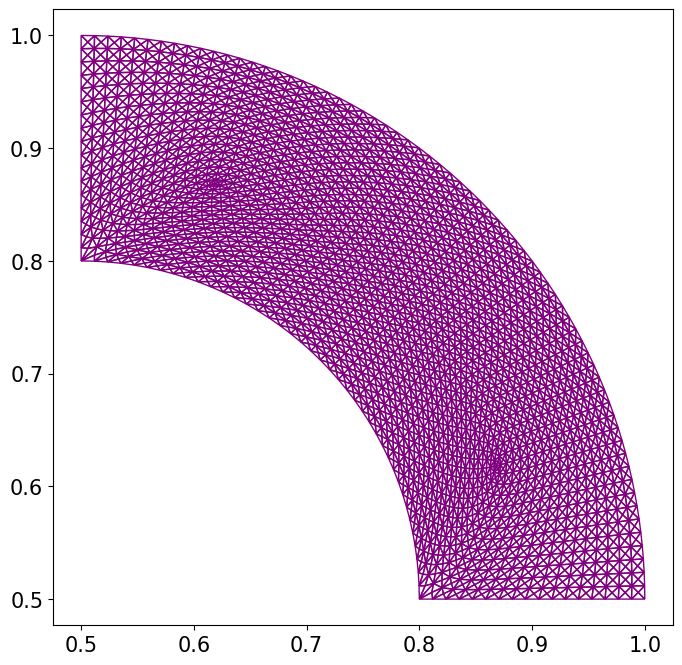

0.36869861108543306

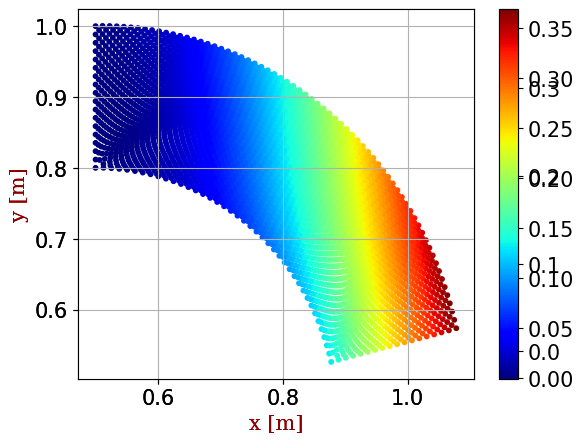

In [20]:
# -*- coding: utf-8 -*-
"""FEM_Plate_T3.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1BRRkFxHNG_KxpFQ7RAmeVjYqenm9RvmN

# 2D plate
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

"""# Part I: Functions

## 1. Solution Function
"""

def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

"""## 2.Shape function T3"""

def shapeFuncT3(xi,eta):
    shape = np.zeros((3,1))
    shape[:,0] = np.array([(1-xi-eta), xi, eta])

    nderiv = np.zeros((3,2))
    nderiv[0,:] = np.array([-1, -1])
    nderiv[1,:] = np.array([1, 0])
    nderiv[2,:] = np.array([0, 1])
    return shape, nderiv

"""## 3. Jacobian Function"""

def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)

    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

"""## 4. Gauss Quadrature T3"""

def gaussQuadratureT3(option):
    if option == 1: # 3 gauss points option 1
        locations = np.array([[0.5, 0.5],
                              [0, 0.5],
                              [0.5, 0]])
        weights = 1/6*np.ones((3,1))
    elif option == 2: # 3 gauss points option 2
        locations = np.array([[1/6, 1/6],
                              [2/3, 1/6],
                              [1/6, 2/3]])
        weights = 1/6*np.ones((3,1))
    elif option == 3: # 4 gauss points
        locations = np.array([[1/3, 1/3],
                              [1/5, 1/5],
                              [3/5, 1/5],
                              [1/5, 3/5]])
        weights = np.array([-27/96, 25/96, 25/96, 25/96])
    else:
        locations = np.array([[1/3, 1/3]])
        weights = 0.5*np.ones((1,1))
    return weights,locations

"""## 5. Stiffness matrix T3"""

def formStiffness2DT3(nDof,nE,eNodes,nP,xy,C,h,gauss_quad_opt):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadratureT3(gauss_quad_opt)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((6,1))
        eDof[0:3,0] = id
        eDof[3:6,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size # number of nodes per element

        # loop for Gauss points
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncT3(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]

            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K



"""## 6. Function_Plot mesh"""

# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

"""# Part 2: Main Programe

## 2.1. Input parameters: geometry & material
"""

# Material Pros
E = 2e11
h = 0.01
pois = 0.3
tol = 1e-6

# Stress- strain matrix: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matrix: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1, pois, 0],[pois, 1, 0],[0, 0, (1-pois)/2]])

"""## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates
"""

# dfnode = pd.read_csv('NLIST_T3a.csv', header=None)
# dfnode = pd.read_csv('NLIST_T3b.csv', header=None)
# dfnode = pd.read_csv('NLIST_T3c.csv', header=None)
# dfnode = pd.read_csv('NLIST_T3d.csv', header=None)
dfnode = pd.read_csv('NLIST_T3e.csv', header=None)

dfnode.head(5)

dfnode = dfnode.dropna(axis=0)
dfnode.head()

dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,0:2]
type(xy)

xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)

"""### 2.2.2. Import nodal connectivities"""

# dfeNode = pd.read_csv('ELIST_T3a.csv', header=None)
# dfeNode = pd.read_csv('ELIST_T3b.csv', header=None)
# dfeNode = pd.read_csv('ELIST_T3c.csv', header=None)
# dfeNode = pd.read_csv('ELIST_T3d.csv', header=None)
dfeNode = pd.read_csv('ELIST_T3e.csv', header=None)

# dfeNode.head()

dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[0,1,2]]

eNodes = dfeNode[[0,1,2]]
nE = eNodes.count(axis=0)
nE = nE[0]

eNodes.head()

eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

"""### 2.2.3 plot mesh"""

PlotMeshb(xy,eNodes,nE)

"""## 2.3. Calculate stiffness matrix"""

K = formStiffness2DT3(nDof,nE,eNodes,nP,xy,C,h,2)
K.shape

"""## 2.4 Boundary condition"""

fixP = np.argwhere(xy[:,0]<=0.5+tol)
fixDof = np.array([fixP,fixP+nP], order = 'F')
fixDof = fixDof.flatten()
fixDof

"""## 2.5 Loading"""

dfx = 5e7
force = np.zeros((nDof,1))

loadP3 = np.argwhere((xy[:,0]>=0.5) & (xy[:,1]<=0.5+tol))
# loadP3
sort_index = np.argsort(xy[loadP3,0].flatten())
# sort_index

loadP = loadP3.copy()
for i in range(len(sort_index)):
    idi = sort_index[i]
    loadP[i] = loadP3[idi,0]
# loadP

for i in range(len(loadP)-1):
    i0 = loadP[i]
    i1 = loadP[i+1]
    dist = np.sqrt((xy[i0,0]-xy[i1,0])**2 + (xy[i0,1]-xy[i1,1])**2)
    force[i0,0] = force[i0,0] + dfx*dist/2
    force[i1,0] = force[i1,0] + dfx*dist/2
# force[loadP]

"""## 2.6. Solve EOM"""

disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

"""## 2.7. Postprocessing"""

scale = 0.2
xNew = xy[:,0] + scale*dispu
yNew = xy[:,1] + scale*dispv

## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

max(dispu)

## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)

plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

max(dispv)